# tvbl

this is a proof of concept "tvb lite" a browser-based [virtual brain](thevirtualbrain.org) Jupyter
environment.  in the workflow here, we do a simulation, then we try to recover the parameters used. 

In [1]:
%pylab inline
import time, tvbl, mdn, scipy.sparse, ipywidgets as w, tqdm

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## interactively choose a simulated ground truth

In [2]:
param_limits = dict(
    a=(1.,1.4,0.01), tau=(1.,2.,0.01), log_k=(-7.,-3.,0.01), log_z=(-1,1,0.01)
)
choices = {'params': None, 'trace': None}

@w.interact(**param_limits)
def run_plot_1(a=0.76, tau=1.0, log_k=-4.02, log_z=-4.0):
    np.random.seed(42)
    
    num_item = 1
    num_node = 90
    num_skip = 1
    dt = 0.1
    sparsity = 0.3
    horizon = 256
    num_time = int(1e2/dt)
    horizonm1 = horizon - 1
    sim_params = np.r_[a, tau, np.exp(log_k)/num_node*80][:,None].astype('f')
    z_scale = np.sqrt(dt)*np.r_[0.01, 0.1].astype('f')*np.exp(log_z)
    choices['params'] = np.r_[a, tau, log_k, log_z]
    
    weights, lengths = np.random.rand(2, num_node, num_node).astype('f')
    lengths[:] *= 0.8
    lengths *= (horizon*dt*0.8)
    zero_mask = weights < (1-sparsity)
    weights[zero_mask] = 0
    csr_weights = scipy.sparse.csr_matrix(weights)
    idelays = (lengths[~zero_mask]/dt).astype('i')+2
    
    y = tvbl.run(
        csr_weights, idelays, sim_params, z_scale, horizon,
        num_item=num_item, num_node=num_node, num_time=num_time,
        dt=dt, num_skip=num_skip, show_time=False,
    )
    choices['trace'] = y
    
    figure(figsize=(8, 2));
    plot(y[:, 0, :, 0], 'k', alpha=0.2);
    grid(1); xlabel('time (ms)'); ylabel('y(t)')

    show()

interactive(children=(FloatSlider(value=1.0, description='a', max=1.4, min=1.0, step=0.01), FloatSlider(value=…

In [3]:
choices['params'], param_limits

(array([ 1.  ,  1.  , -4.02, -1.  ]),
 {'a': (1.0, 1.4, 0.01),
  'tau': (1.0, 2.0, 0.01),
  'log_k': (-7.0, -3.0, 0.01),
  'log_z': (-1, 1, 0.01)})

## features

let's use simple means, variance and average fft

In [4]:
choices['trace'].shape

(1001, 2, 90, 1)

In [5]:
def features(trace):
    x = trace[200:, 0]
    mu = x.mean(axis=0)
    std = x.std(axis=0)
    ft = np.abs(np.fft.fft(x[-256:], axis=0).mean(axis=1))
    return np.concatenate([mu, std, ft]).astype('f')

choices['features'] = features(choices['trace'])
choices['features'].shape

(436, 1)

to know if these are useful, we should sample and look at the distribution of covariance

## Sample prior distribution

We establish a prior and a function to sample from it

In [6]:
p_lo, p_hi = np.zeros((2, 4))
for i, key in enumerate('a tau log_k log_z'.split(' ')):
    p_lo[i] = param_limits[key][0]
    p_hi[i] = param_limits[key][1]

def sample_prior(num_item):
    u = np.random.uniform(size=(p_lo.size, num_item)).T
    u *= p_hi - p_lo
    u += p_lo
    return u.T.astype('f')

sample_prior(3)

array([[ 1.0957402 ,  1.1510969 ,  1.3144447 ],
       [ 1.9382775 ,  1.943941  ,  1.0482781 ],
       [-4.2325106 , -4.0434012 , -5.3022647 ],
       [ 0.93805724, -0.57226634,  0.54184717]], dtype=float32)

## Sample prior predictive distribution

To sample the prior predictive distribution, we map each prior sample through the simulator to obtain data features.

In [7]:
sample_params = []
sample_features = []

for i_batch in tqdm.trange(num_batch := 32):
    num_item = 32
    num_node = 90
    num_skip = 1
    dt = 0.1
    sparsity = 0.3
    horizon = 256
    num_time = int(1e2/dt)
    horizonm1 = horizon - 1
    sim_params = sample_prior(num_item)
    sample_params.append(sim_params.copy())
    sim_params[2] = np.exp(sim_params[2])/num_node*80 # k
    z_scale = np.sqrt(dt)*np.r_[0.01, 0.1].astype('f')[:,None]*np.exp(sim_params[3])
    sim_params = sim_params[:3]  # keep z separate
    
    weights, lengths = np.random.rand(2, num_node, num_node).astype('f')
    lengths[:] *= 0.8
    lengths *= (horizon*dt*0.8)
    zero_mask = weights < (1-sparsity)
    weights[zero_mask] = 0
    csr_weights = scipy.sparse.csr_matrix(weights)
    idelays = (lengths[~zero_mask]/dt).astype('i')+2
    
    y = tvbl.run(
        csr_weights, idelays, sim_params, z_scale, horizon,
        num_item=num_item, num_node=num_node, num_time=num_time,
        dt=dt, num_skip=num_skip, show_time=False
    )

    sample_features.append(features(y))

sample_params = np.array(sample_params).transpose(1, 0, 2).reshape(-1, num_batch*num_item)
sample_features = np.array(sample_features).transpose(1, 0, 2).reshape(-1, num_batch*num_item)

100%|████████████████████████████████████████████████████| 32/32 [00:28<00:00,  1.12it/s]


In [8]:
# TODO put into mdn
ok = np.isfinite(sample_features).all(axis=0)
sample_params = sample_params[:, ok]
sample_features = sample_features[:, ok]
print(f'dropped {(~ok).sum()} non finite samples, leaving {ok.sum()} samples')

dropped 0 non finite samples, leaving 1024 samples


## Train regressor

In [9]:
mdn_w, _, mdn_f = mdn.train_mdn(
    sample_params.T,
    sample_features.T,
    K=3, H=(128, 32),
    niter=800,
)

/home/duke/env/tvbl/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:175: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh, lambda ans, x: lambda g: g / anp.cosh(x) ** 2)


Starting training...
Iteration     1/800, Loss: 17.6696
Iteration   100/800, Loss: 2.6281
Iteration   200/800, Loss: 0.5642


/home/duke/env/tvbl/lib/python3.11/site-packages/autograd/tracer.py:54: RuntimeWarning: overflow encountered in cosh
  return f_raw(*args, **kwargs)


Iteration   300/800, Loss: -0.2533
Iteration   400/800, Loss: -0.6561
Iteration   500/800, Loss: -0.9636
Iteration   600/800, Loss: -1.2028
Iteration   700/800, Loss: -1.3997
Iteration   800/800, Loss: -1.4914
Training finished.


## Apply regressor

Once training is done, inference (conditioning joint distribution on data) is *amortized* meaning it is quite fast (enabling even real time applications)

In [10]:
%timeit -n50 -r5 mdn.sample(mdn_w, mdn_f, choices['features'][:,0], 200)
post_params = mdn.sample(mdn_w, mdn_f, choices['features'][:,0], 200)

The slowest run took 6.55 times longer than the fastest. This could mean that an intermediate result is being cached.
545 μs ± 560 μs per loop (mean ± std. dev. of 5 runs, 50 loops each)


## Evaluate

In this simple case, we just look at the posteriors along with the true values

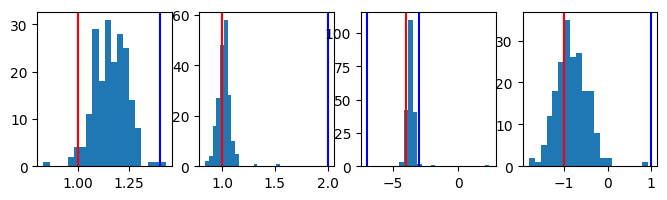

In [11]:
figure(figsize=(8,2))
for i in range(4):
    subplot(1, 4, i+1)
    axvline(p_lo[i], color='b')
    axvline(p_hi[i], color='b')
    hist(post_params[:,i], 20)
    axvline(choices['params'][i], color='r')

we can see that the true value (in red) lies in the posterior distribution which has shrunk from the prior (blue lines).